## Data Loading

In [1]:
pip install matplotlib seaborn psycopg2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import psycopg2

conn = psycopg2.connect(
    host="localhost",
    database="reliability_analysis",
    user="postgres",
    password=11071995
)

query = "Select * from predictive_maintenance;"
df = pd.read_sql(query, conn)

df.head()

C:\Users\heman\AppData\Local\Temp\ipykernel_28816\942067174.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,udi,product_id,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# SQL Insights

### Visualization 1 - Failure Rate (%) by Machine Type

<Axes: xlabel='type'>

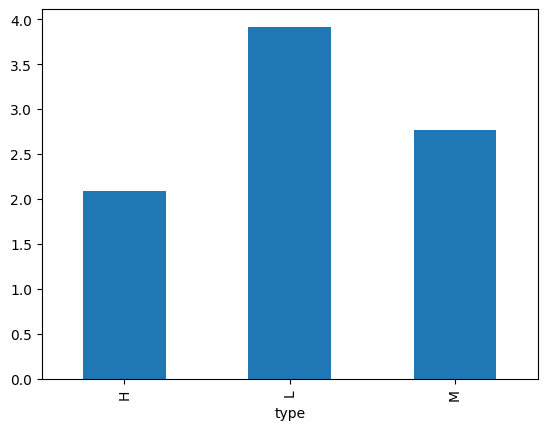

In [3]:
failure_by_type = df.groupby("type")["machine_failure"].mean() * 100

failure_by_type.plot(kind="bar")

## Visualization 2 - Failure Probability by Tool Wear Level

<Axes: xlabel='wear_bucket'>

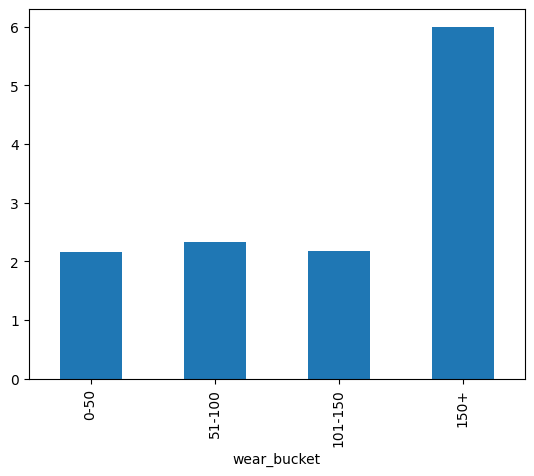

In [4]:
df["wear_bucket"] = pd.cut(
    df["tool_wear"],
    bins=[0,50,100,150,250],
    labels=["0-50","51-100","101-150","150+"]
)

wear_failure = df.groupby("wear_bucket")["machine_failure"].mean() *100

wear_failure.plot(kind="bar")

## Visualization 3 - Torque Distribution: Failure vs Non-Failure

([<matplotlib.axis.XTick at 0x18ca98bfb10>,
 [Text(0, 0, 'No Failure'), Text(1, 0, 'Failure')])

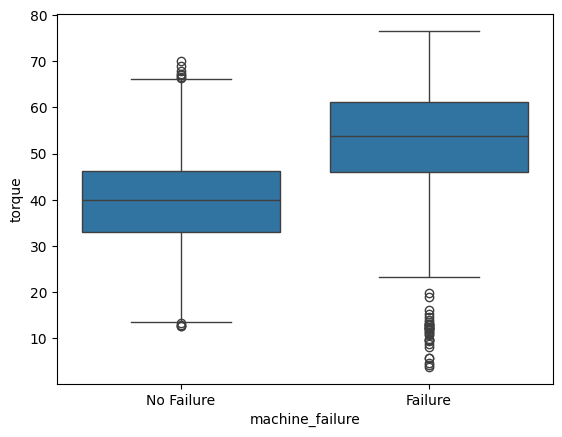

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x="machine_failure", y="torque", data=df)
plt.xticks([0,1], ["No Failure", "Failure"])

# Modeling

In [6]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Feature Selection
X = df[["air_temperature", "process_temperature", "rotational_speed", "torque", "tool_wear"]]

y = df["machine_failure"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

In [9]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1930    9]
 [  45   16]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.64      0.26      0.37        61

    accuracy                           0.97      2000
   macro avg       0.81      0.63      0.68      2000
weighted avg       0.97      0.97      0.97      2000



In [10]:
import pandas as pd

coefficients = pd.DataFrame({
    "Feature":X.columns,
    "Coefficient":model.coef_[0]
})

coefficients.sort_values(by="Coefficient", ascending=False)

,Feature,Coefficient
3,torque,2.744022
2,rotational_speed,2.038420
0,air_temperature,1.487684
4,tool_wear,0.823580
1,process_temperature,-1.006670


In [11]:
y_prob = model.predict_proba(X_test_scaled)[:,1]

In [12]:
print(y_prob)

[0.01320238 0.03103062 0.01017797 ... 0.00664836 0.15754215 0.00678732]


In [13]:
y_prob[:10]

array([0.01320238, 0.03103062, 0.01017797, 0.00375441, 0.02285455,
       0.04713568, 0.03613351, 0.08067721, 0.00452857, 0.00039066])

## Evaluation

In [14]:
import numpy as np

top_risk_indices = np.argsort(y_prob)[-10:]
df.iloc[top_risk_indices][["tool_wear","torque","machine_failure"]]

,tool_wear,torque,machine_failure
1253,0,57.3,0
1637,102,33.9,0
1774,29,37.3,0
1534,71,29.1,0
119,106,40.7,0
1537,78,39.6,0
1182,23,48.1,0
1043,90,45.2,0
1708,64,31.5,0
1131,123,33.4,0


In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.64      0.26      0.37        61

    accuracy                           0.97      2000
   macro avg       0.81      0.63      0.68      2000
weighted avg       0.97      0.97      0.97      2000



In [16]:
model = LogisticRegression(class_weight='balanced')

In [17]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_scaled, y_train)

y_pred_bal = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_bal))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1939
           1       0.13      0.85      0.22        61

    accuracy                           0.82      2000
   macro avg       0.56      0.83      0.56      2000
weighted avg       0.97      0.82      0.88      2000



In [18]:
y_prob = model.predict_proba(X_test_scaled)[:,1]

## Risk Scoring

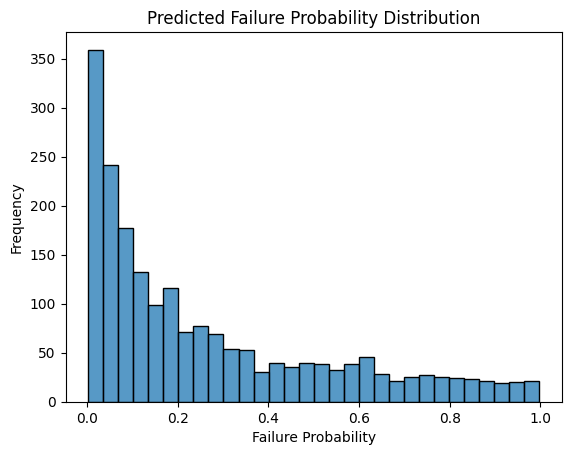

In [32]:
plt.figure()
sns.histplot(y_prob, bins=30)
plt.title("Predicted Failure Probability Distribution")
plt.xlabel("Failure Probability")
plt.ylabel("Frequency")
plt.savefig("visuals/wear_risk.png", bbox_inches='tight')
plt.show()

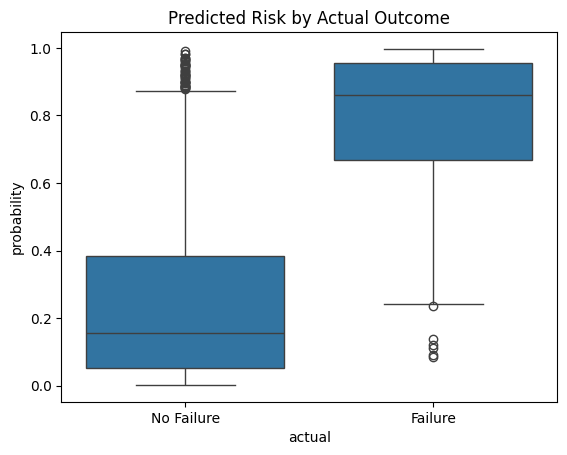

In [33]:
prob_df = pd.DataFrame({
    "probability":y_prob,
    "actual":y_test.values
})

plt.figure()
sns.boxplot(x="actual", y="probability", data = prob_df)
plt.xticks([0,1], ["No Failure", "Failure"])
plt.title("Predicted Risk by Actual Outcome")
plt.savefig("visuals/wear_risk_outcome.png", bbox_inches='tight')
plt.show()